In [2]:
import sys

In [3]:
!{sys.executable} -m pip install isodate

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [4]:
!{sys.executable} -m pip install wordcloud

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [8]:
from googleapiclient.discovery import build
import pandas as pd
from IPython.display import JSON
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# NLP
from wordcloud import WordCloud
from nltk.corpus import stopwords


import json

In [12]:
with open('credentials.json') as file:
    credentials = json.load(file)

In [17]:
api_key = credentials['api_key']

In [18]:
channel_ids = ['UCoOae5nYA7VqaXzerajD0lg',
               # more channlers here
              ]

In [19]:
api_service_name = "youtube"
api_version = "v3"
#client_secrets_file = "YOUR_CLIENT_SECRET_FILE.json"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)



In [20]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

In [21]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [22]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Ali Abdaal,3750000,264783551,547,UUoOae5nYA7VqaXzerajD0lg


In [23]:
def get_video_ids(youtube, channel_ids):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                channelId = channel_ids[0],
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [24]:
playlist_id = "UUoOae5nYA7VqaXzerajD0lg"

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

In [25]:
video_ids = get_video_ids(youtube, playlist_id)

In [26]:
len(video_ids)

544

In [27]:
request = youtube.videos().list(
    part="snippet,contentDetails,statistics",
    id=video_ids[0:5]
)
response = request.execute()

JSON(response)

<IPython.core.display.JSON object>

In [28]:
def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

In [29]:
video_df = get_video_details(youtube, video_ids)

In [30]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,Mtknzfv9dUY,Ali Abdaal,Neuroscientist on how journalling changes your...,"If you liked this, you might like the full epi...","[Ali Abdaal, Ali abdal]",2023-01-17T14:00:10Z,10090,1270,None,15,PT59S,hd,false
1,tyLu_RQWicc,Ali Abdaal,Caspar Lee on the Struggles of Being a YouTube...,If you liked this you might like the full epis...,"[Ali Abdaal, Ali abdal]",2023-01-16T13:00:30Z,18716,790,None,19,PT59S,hd,false
2,f8BqU9wUbP0,Ali Abdaal,The Science of Stress & How to Reduce It #shorts,If you enjoyed this you might enjoy my podcast...,"[Ali Abdaal, Ali abdal]",2023-01-15T13:00:32Z,45326,3595,None,34,PT37S,hd,false
3,0K1nA46Bink,Ali Abdaal,AI definitely didn't write this short 🤖 #shorts,If you liked this you might like my podcast de...,"[Ali Abdaal, Ali abdal]",2023-01-13T13:00:01Z,41966,2560,None,33,PT59S,hd,false
4,O3m14PVOq_g,Ali Abdaal,How to Find a Career You Actually Love,It can be really daunting knowing how to appro...,"[Ali Abdaal, Ali abdal, career, how to find th...",2023-01-12T15:00:24Z,147737,7606,None,315,PT12M41S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04T23:13:51Z,78629,2016,None,115,PT2M35S,hd,false
540,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09T18:45:18Z,14029,101,None,4,PT2M11S,hd,false
541,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27T09:04:49Z,35199,263,None,8,PT2M18S,hd,false
542,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05T09:05:29Z,50124,626,None,29,PT2M29S,hd,false


In [31]:
def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [32]:
comments_df = get_comments_in_videos(youtube, video_ids)
comments_df

Could not get comments for video P6xJm38guuM


,video_id,comments
0,Mtknzfv9dUY,"[If you liked this, you might like the full ep..."
1,tyLu_RQWicc,[If you enjoyed this you check out the full ep...
2,f8BqU9wUbP0,[C-ptsd... There is no hope for me just to mil...
3,0K1nA46Bink,[What's the purpose of AI? Which labour force ...
4,O3m14PVOq_g,"[If you enjoyed this video, you might like my ..."
...,...,...
538,7APfFjfnNBc,"[Wow, Katherine is hotter tbh, I think that th..."
539,gBpBLTSCb4s,[joined their 6med ucat crash course in jan 20...
540,Va0tSdPADpA,"[Ali 3rd viedeo, Where is ali?, wait WHAT, I l..."
541,XJHM0fEH3ss,[Watching this video after the one called How ...


## Data pre-processing

In [33]:
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [34]:
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [35]:
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [36]:
# Public say in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x))
video_df['publishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A"))

In [37]:
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [38]:
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,59.0,PT59S
1,59.0,PT59S
2,37.0,PT37S
3,59.0,PT59S
4,761.0,PT12M41S
...,...,...
539,155.0,PT2M35S
540,131.0,PT2M11S
541,138.0,PT2M18S
542,149.0,PT2M29S


In [39]:
# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [40]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,publishDayName,durationSecs,tagCount
0,Mtknzfv9dUY,Ali Abdaal,Neuroscientist on how journalling changes your...,"If you liked this, you might like the full epi...","[Ali Abdaal, Ali abdal]",2023-01-17 14:00:10+00:00,10090.0,1270.0,NaN,15.0,PT59S,hd,false,Tuesday,59.0,2
1,tyLu_RQWicc,Ali Abdaal,Caspar Lee on the Struggles of Being a YouTube...,If you liked this you might like the full epis...,"[Ali Abdaal, Ali abdal]",2023-01-16 13:00:30+00:00,18716.0,790.0,NaN,19.0,PT59S,hd,false,Monday,59.0,2
2,f8BqU9wUbP0,Ali Abdaal,The Science of Stress & How to Reduce It #shorts,If you enjoyed this you might enjoy my podcast...,"[Ali Abdaal, Ali abdal]",2023-01-15 13:00:32+00:00,45326.0,3595.0,NaN,34.0,PT37S,hd,false,Sunday,37.0,2
3,0K1nA46Bink,Ali Abdaal,AI definitely didn't write this short 🤖 #shorts,If you liked this you might like my podcast de...,"[Ali Abdaal, Ali abdal]",2023-01-13 13:00:01+00:00,41966.0,2560.0,NaN,33.0,PT59S,hd,false,Friday,59.0,2
4,O3m14PVOq_g,Ali Abdaal,How to Find a Career You Actually Love,It can be really daunting knowing how to appro...,"[Ali Abdaal, Ali abdal, career, how to find th...",2023-01-12 15:00:24+00:00,147737.0,7606.0,NaN,315.0,PT12M41S,hd,false,Thursday,761.0,18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,7APfFjfnNBc,Ali Abdaal,Payphone (Maroon 5) - Katherine Macfarland & A...,"First cover of 2017! We both love this song, s...","[payphone, maroon 5, acoustic cover, cover]",2017-01-04 23:13:51+00:00,78629.0,2016.0,NaN,115.0,PT2M35S,hd,false,Wednesday,155.0,4
540,gBpBLTSCb4s,Ali Abdaal,6med UKCAT Crash Course - In a Nutshell,The 6med UKCAT Crash Course is the most effect...,"[6med, medical school, ukcat, medicine]",2016-05-09 18:45:18+00:00,14029.0,101.0,NaN,4.0,PT2M11S,hd,false,Monday,131.0,4
541,Va0tSdPADpA,Ali Abdaal,6med BMAT Crash Course - In a Nutshell,The 6med BMAT Crash Course is the most effecti...,"[BMAT, 6med, medicine, medical students]",2016-04-27 09:04:49+00:00,35199.0,263.0,NaN,8.0,PT2M18S,hd,false,Wednesday,138.0,4
542,XJHM0fEH3ss,Ali Abdaal,Rolling in the Deep (Adele) - Duranka Perera &...,Our first 'proper' video! One of our all-time ...,"[rolling in the deep, adele, cover, acoustic]",2016-04-05 09:05:29+00:00,50124.0,626.0,NaN,29.0,PT2M29S,hd,false,Tuesday,149.0,4


# EDA

## Best performing videos

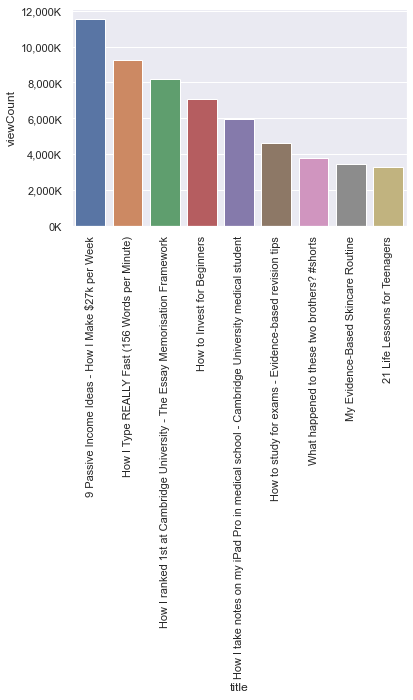

In [41]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## Worst performing videos

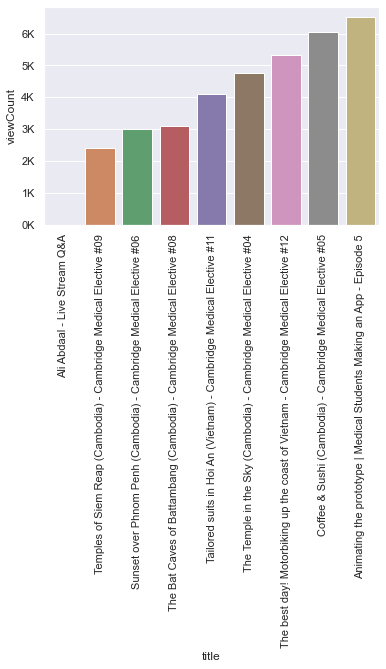

In [42]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

## View distribution per video

In [43]:
sns.violinplot(video_df['channelTitle'], video_df['viewCount'])

TypeError: violinplot() takes from 0 to 1 positional arguments but 2 were given

## Views vs. likes and comments

<AxesSubplot: xlabel='likeCount', ylabel='viewCount'>

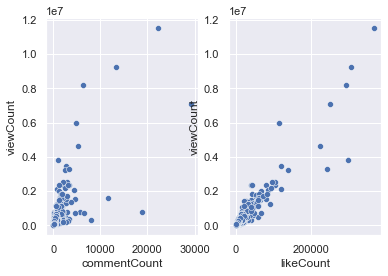

In [44]:
fig, ax = plt.subplots(1, 2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y= 'viewCount', ax = ax[1])

### Video duration

<AxesSubplot: xlabel='durationSecs', ylabel='Count'>

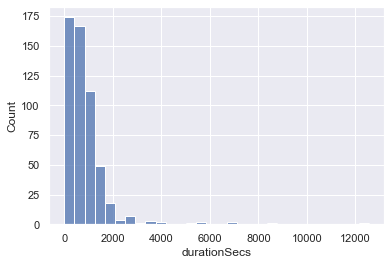

In [45]:
sns.histplot(data = video_df, x = 'durationSecs', bins=30)

 ## Wordcloud for video titles

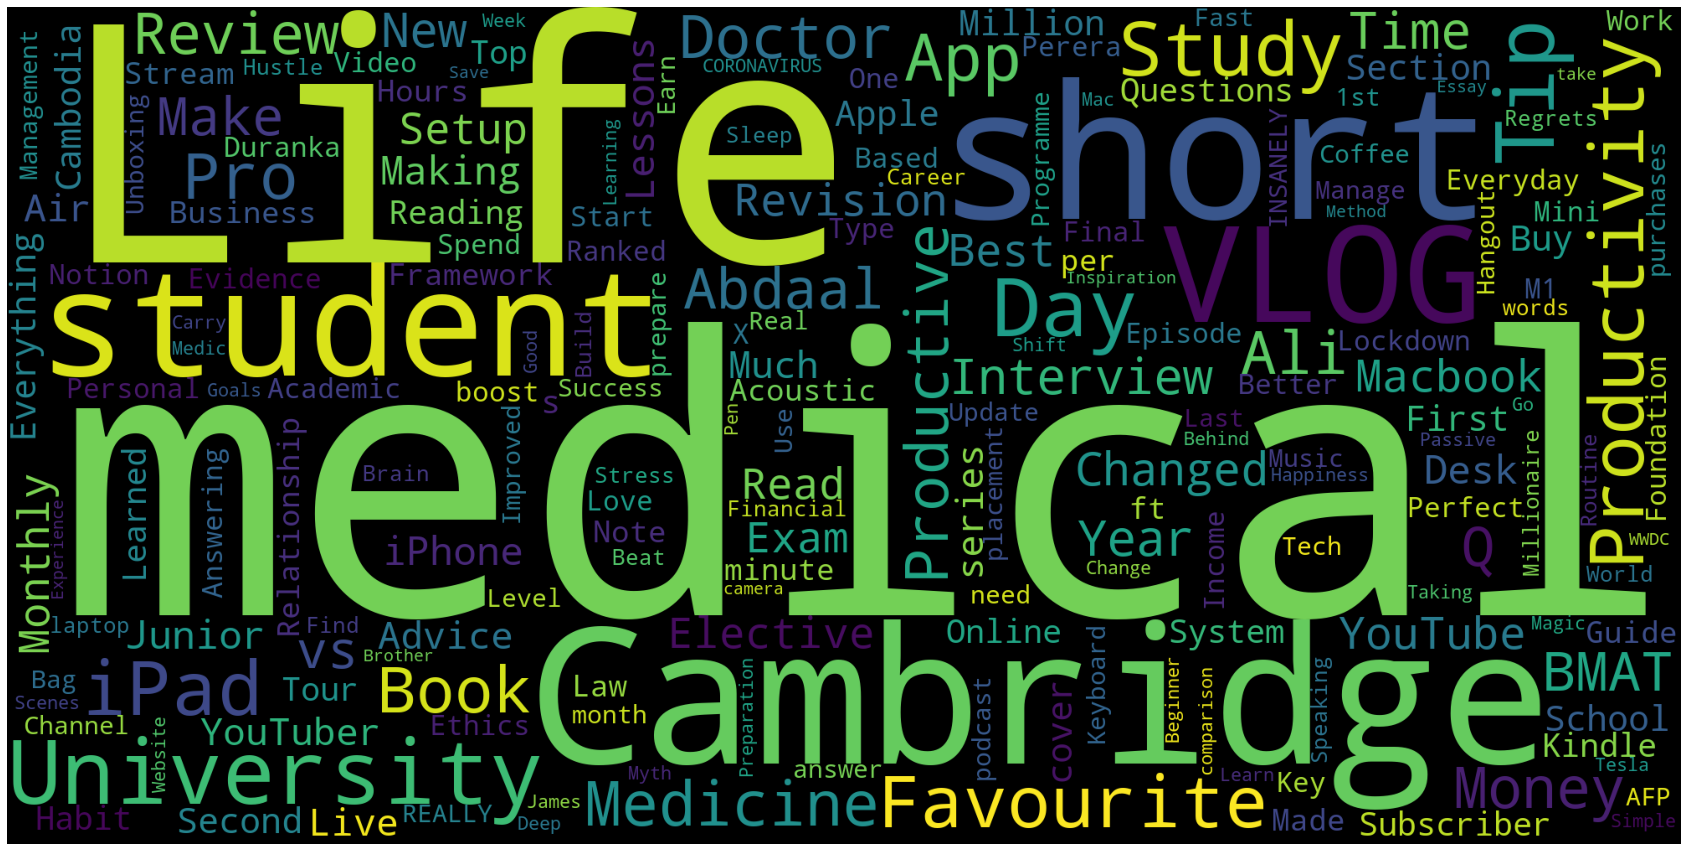

In [46]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words)

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

### Upload schedule

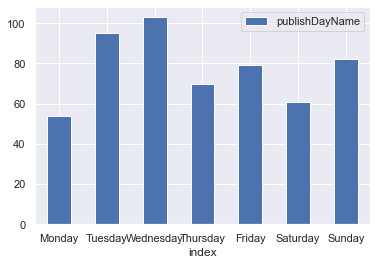

In [47]:
day_df = pd.DataFrame(video_df['publishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='publishDayName', rot=0)